# Bayesian regression for storm erosion prediction
Joshua Simmons 05/2022

In [1]:
# magic
%load_ext autoreload
%autoreload 2
%pdb 1
%matplotlib inline

Automatic pdb calling has been turned ON


## Imports and settings

In [70]:
import os, sys
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

from ipywidgets import interactive, fixed, widgets

# MAP regression
import sklearn.linear_model as lm

# pymc3

import pymc3 as pm

from pymc3 import HalfCauchy, Model, Normal, sample

import urllib.request

## Download wave data

## Download shoreline data

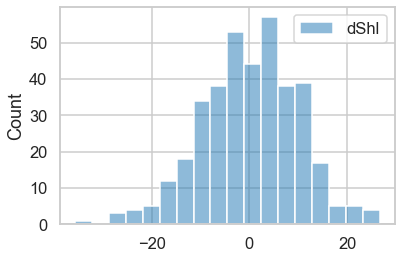

In [82]:
transectName = 'aus0206-0005'
csSource = 'http://coastsat.wrl.unsw.edu.au/time-series/{}/'
tmpLoc =  "working_data.csv"
download = False

if download:
    urllib.request.urlretrieve(csSource.format(transectName), tmpLoc)

shlData = pd.read_csv(tmpLoc,parse_dates=True,index_col=0,header=None)
shlData.columns = ['Shoreline']
shlData.index.name = 'Date'
# shlData.plot()

diffShlData = shlData.diff()
diffShlData.columns = ['dShl'] 

sns.histplot(diffShlData.dropna())
None

## Convert to storm dataset

## Generate toy data

In [3]:
# Generate data that follows a power law distribution
# y = a * x^b + error
#defaults
powa = 0.05
constb = 1.5
err_var = 0.15
hs_scale = 0
# Plot x, y data

def generate_data(powa, constb, err_var, hs_scale, n_points, log_scale=False):
    print('Choose a and b in y = a * x^b')
    x = np.around(np.random.uniform(0, 10, n_points),decimals=2)

    # generate the error
    err = np.random.normal(0, err_var, len(x))
    # add a homoscedastic error
    err += (err * x) * hs_scale


    y = (powa * x**constb) + err

    plt.plot(x, y, 'o',label='Data')
    xReal = np.linspace(0,10,100)
    yReal = powa * xReal**constb
    plt.plot(xReal,yReal,'r-',label='True function')

    plt.xlabel('x')
    plt.ylabel('y')
    # change axes to log - log scale
    if log_scale:
        plt.xscale('log')
        plt.yscale('log')
    plt.title('Power Law Distribution')
    plt.legend(loc='center', bbox_to_anchor=(1.1,0.5))
    plt.show()

    return x, y

result = interactive(
    generate_data,
    powa = widgets.FloatText(value=powa,description='a',step=0.05), 
    constb = widgets.FloatText(value=constb,description='b',step=0.5),
    err_var = widgets.FloatText(value=err_var,description='variance',step=0.05),
    hs_scale = widgets.FloatText(value=hs_scale,description='homoscedasticity',step=0.05),
    n_points = widgets.IntSlider(value=5,min=5,max=100,step=5,description='n_points'),
    log_scale=False
)

display(result)



interactive(children=(FloatText(value=0.05, description='a', step=0.05), FloatText(value=1.5, description='b',…

In [63]:
x, y = result.result
print('x: {}\ny: {}'.format(x.shape,y.shape))

# and trasnform to logspace
x_log = np.log(x)
y_log = np.log(y)

x: (40,)
y: (40,)


## Setup plotting functions

In [56]:
def draw_fit(xObs,yObs,xPred,yPred,ySample=None,yMAP=None,**kwargs):
    fig = plt.figure(figsize=(7, 5))
    ax1 = fig.add_subplot(111)

    # if kwargs.get('errBands',False):
    #     ax1.fill_between(xSample, predyMean - 1.96*predyStd, predyMean + 1.96*predyStd, alpha=0.2,label='95% CI')
    #     ax1.plot(xSample, sampleyMean[:,0],label='Samples')
    #     ax1.plot(xSample, sampleyMean[:,1:])
    # else:
    #     ax1.plot(xSample, sampleyMean)#,label='Samples')

    if not ySample is None:
        ax1.plot(xPred, ySample[0,:].T,'-',color='xkcd:light grey',alpha=0.4,label='Samples')
        ax1.plot(xPred, ySample[1:,:].T,'-',color='xkcd:light grey',alpha=0.4)

    if not yMAP is None:
        ax1.plot(xPred, yMAP.T,'-',color='xkcd:red',label='MAP fit')

    # # plot mean
    # ax1.plot(xSample, predyMean, 'k', label='Mean')

    # if not y is None:
    ax1.plot(xObs, yObs, 'o',color='xkcd:dark grey',label='Observed')
    ax1.plot(xPred, yPred, 'C0', label='Predicted')
    
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')

    if kwargs.get('log_scale',False):
        ax1.set_xscale('log')
        ax1.set_yscale('log')

    ax1.set_title(kwargs.get('title','Power Law Distribution Fit'))
    # place legend outside the plot
    plt.legend(loc='center', bbox_to_anchor=(1.2, 0.5))
    plt.show()
    return ax1

## Fit a Bayesian Linear Regression in logspace - MAP

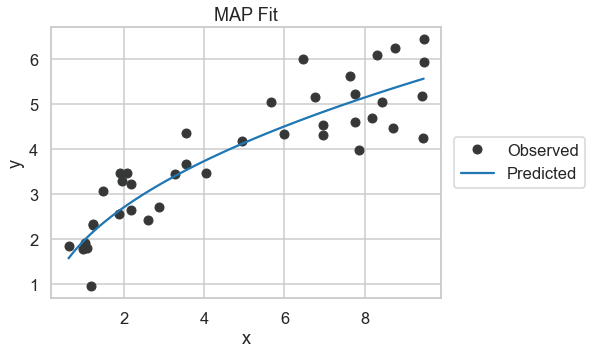

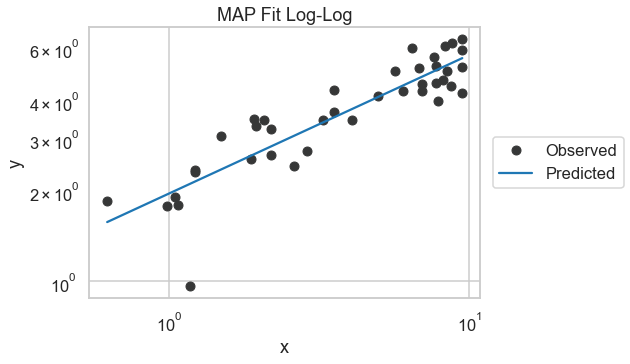

In [66]:
# fit a linear model to the data
model = lm.LinearRegression()
model.fit(x_log.reshape(-1,1),y_log)

sample_x = np.linspace(x.min(),x.max(),101)

y_pred = model.predict(np.log(sample_x).reshape(-1,1))

draw_fit(x,y,sample_x,np.exp(y_pred),title='MAP Fit')

draw_fit(x,y,sample_x,np.exp(y_pred),log_scale=True,title='MAP Fit Log-Log')

None

## Fit with pymc3

In [67]:
with Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = Normal("Intercept", 0, sigma=20)
    x_coeff = Normal("x", 0, sigma=20)

    # Define likelihood
    likelihood = Normal("y", mu=intercept + x_coeff * x_log, sigma=sigma, observed=y_log)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    trace = sample(3000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept, sigma]


/Users/jsim3774/opt/anaconda3/envs/pymc/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/jsim3774/opt/anaconda3/envs/pymc/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/jsim3774/opt/anaconda3/envs/pymc/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/jsim3774/opt/anaconda3/envs/pymc/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 23 seconds.


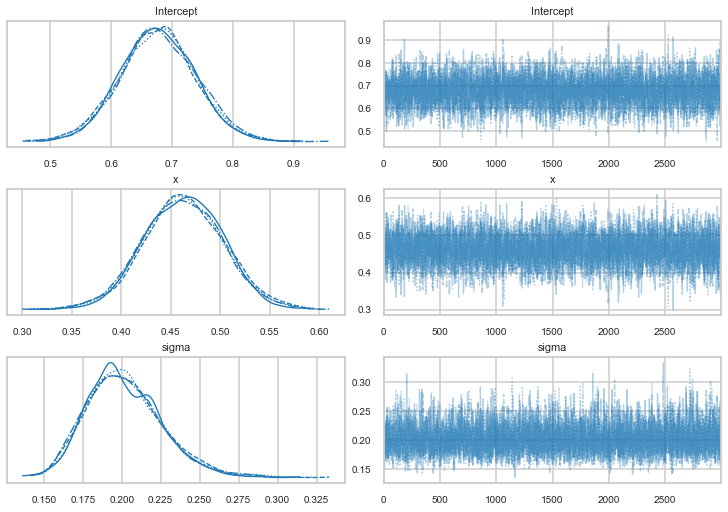

In [68]:
import arviz as az
az.plot_trace(trace, figsize=(10, 7));

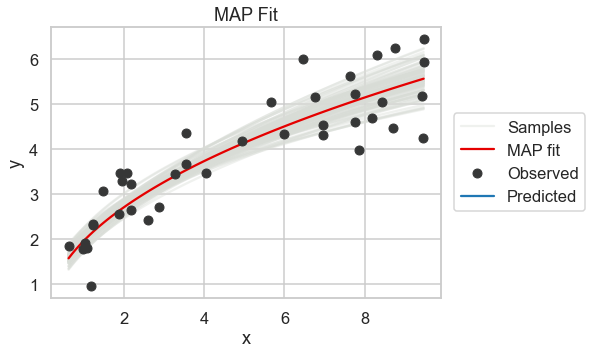

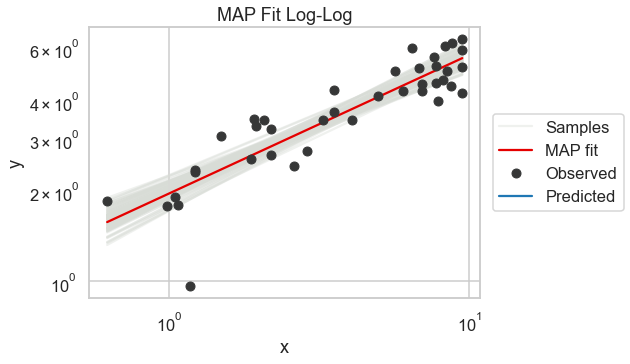

In [69]:
nSamples = 100

# generate draws from the posterior
eval_lm = lambda x, sample: sample["Intercept"] + sample["x"] * x
if not isinstance(trace, list):
    trace = trace.posterior.to_dataframe().to_dict(orient="records")
ySample = np.zeros((nSamples, len(sample_x)))
for ii, rand_loc in enumerate(np.random.randint(0, len(trace), nSamples)):
    rand_sample = trace[rand_loc]
    tmpSample = eval_lm(np.log(sample_x), rand_sample)
    ySample[ii,:] = tmpSample

mapParams = pm.find_MAP(model=model)
yMAP = eval_lm(np.log(sample_x), mapParams)

draw_fit(
    x,y,
    sample_x,np.full(sample_x.shape, np.nan),
    ySample=np.exp(ySample),yMAP=np.exp(yMAP),
    title='MAP Fit')

draw_fit(
    x,y,
    sample_x,np.full(sample_x.shape, np.nan),
    ySample=np.exp(ySample),yMAP=np.exp(yMAP),
    log_scale=True,title='MAP Fit Log-Log')

None
